
## Objective
The objective of this assignment is to give you hands-on experience with deep learning packages, such as pyTorch. The task here is to build a model that takes an image as input and produces a single number. The image contains three digits consisting only of digits 1,2 and 3. The output of the model should be the product of these digits. It is up to you to choose the model architecture. You may choose to first predict each digit and then calculate their product, or calculate the product in one shot. You may approach this as a classification task since the output options are limited, or consider it as a regression task. 



## The dataset
Use the following code to load the data using the npy files. We have 11,000 training examples, where each image is 64x64. Labels are the product of numbers in each image. The label is printed at the top of each example shown below.

In [1]:
#importing the datasets from my google drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/datasets")

Mounted at /content/drive


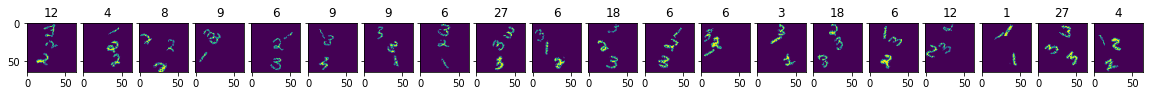

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid                        

x = np.load('x_train.npy') #11,000 x 64 x 64
y = np.load('y_train.npy')
xt = np.load('x_test.npy')
yt = np.load('y_test.npy')
def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((64,64)))
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

## Preprocessing 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#initate the one hot encoder
onehot = OneHotEncoder(sparse = False)
#make the training labels veritcle
y_train = y.reshape(-1, 1)
# transform training labels into one hot encoding and then back again
# this changes the labels from (1,2,3,...,27) to (0,1,2,...,9)
y_train = onehot.fit_transform(y_train)
y_train=torch.from_numpy(y_train)
y_train= torch.argmax(y_train, dim=1)

#make the test labels veritcle
y_test = yt.reshape(-1, 1)
# transform test labels into one hot encoding and then back again
# this changes the labels from (1,2,3,...,27) to (0,1,2,...,9)
y_test = onehot.fit_transform(y_test)
y_test=torch.from_numpy(y_test)
y_test= torch.argmax(y_test, dim=1)

#Transform the x_training data and combining it with the y_train data to create a data set so that 
#it the data is easier to work with
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
x = np.array(x, np.float64)
x2=transform(x)
x2=x2.transpose(1,0)
data=TensorDataset(x2,y_train)
trainloader = torch.utils.data.DataLoader(dataset=data, batch_size=5,shuffle=True, num_workers=2)


#Transform the first half of the x_yest data and combining it with the y_test data to create a 
#dataset so that the data is easier to work with
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
x2t=xt[:4500]
x2t = np.array(x2t, np.float64)
x2t=transform(x2t)
x2t=x2t.transpose(1,0)
data2=TensorDataset(x2t,y_test)
testloader = torch.utils.data.DataLoader(dataset=data2, batch_size=5,shuffle=False, num_workers=2)

#Transform x_yest data using it as a dataset on its own as there isn't labels for all 9000 images
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])
x2t2 = np.array(xt, np.float64)
x2t2=transform(x2t2)
x2t2=x2t2.transpose(1,0)
testloader2 = torch.utils.data.DataLoader(x2t2, batch_size=5,shuffle=False, num_workers=2)


# Model and its training


In [7]:
class Net(nn.Module):
    #creates a 7 layer deep CNN model
    #each layer other than the first either double or keeps the same number of channels
    #each layer has the standard kernel size of 3, stride of 1, and padding of 1
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1).double()
        self.relu1=nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=24,kernel_size=3,stride=1,padding=1).double()
        self.relu2=nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1).double()
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1).double()
        self.relu4 = nn.ReLU()
        self.conv5= nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1).double()
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1).double()
        self.relu6 = nn.ReLU()
        self.conv7= nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1).double()
        self.relu7 = nn.ReLU()
        self.fc = nn.Linear(in_features=32*32*96,out_features=10).double()

    #run the data on all 7 layers with a relu inbetween each one
    #have only one pool after the second layers as I found that worked the best for my model
    #same is true with having only one fc call right at the end
    def forward(self, x):
        x=x.unsqueeze(0)
        x=x.permute(1,0,2,3)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.relu7(x)
        x = x.view(-1, 32 * 32 * 96)
        x = self.fc(x)
        return x
net = Net()
#Define the optimizer and loss function
#learning rate is a variable as it gets changed during training
loss_fn = nn.CrossEntropyLoss()
lr=0.001
optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
#five epochs produced the best test accuracy on this model
for epoch in range(5):  # loop over the dataset multiple times

    #initiate variables to keep track of accuracy
    train_acc = 0.0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward then backwards then optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        #get predicitons and compare to actual
        _, prediction = torch.max(outputs.data, 1) 
        train_acc += torch.sum(prediction == labels)
    train_acc = train_acc / 11000 
    #divide learning rate by 4 after every epoch so model is constantly adjusting how it learns
    lr=lr/4
    # print statistics
    print("Epoch {}, Train Accuracy: {}".format(epoch, train_acc))
print('Finished Training') 
    

Epoch 0, Train Accuracy: 0.3338181674480438
Epoch 1, Train Accuracy: 0.710454523563385
Epoch 2, Train Accuracy: 0.840363621711731
Epoch 3, Train Accuracy: 0.898727297782898
Epoch 4, Train Accuracy: 0.9169090986251831
Finished Training


# Accuracy metrics and CSV submission to Kaggle

In [9]:

#test method that tests on the first half of the test data with labels
def test():
      test_acc = 0.0
      total=0
      for data in testloader:
        images, labels = data
        outputs = net(images) 
        _, predicted = torch.max(outputs.data, 1)
        test_acc +=torch.sum(predicted == labels.data)
      return (test_acc/4500) 

accuracy=test()      
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')
# <<< your code here

The accuracy of the model that should match the public leaderboard accuracy is tensor(89.0222) %


In [10]:
import pandas as pd 
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels2.csv',index=False)
    pass
#predict method to get the prediction for all 9000 test images
#creates an empty array then appends the predicitons to it 
def predict():
      a=np.zeros(0)
      for data in testloader2:
        images= data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        a=np.append(a,predicted)
      return a       
yh_test = predict().astype(int) 
#Changing labels back from (0,1,2,...,9) to (1,2,3,...,27)
yh_test[yh_test==9]=27
yh_test[yh_test==8]=18
yh_test[yh_test==7]=12
yh_test[yh_test==6]=9
yh_test[yh_test==5]=8
yh_test[yh_test==4]=6
yh_test[yh_test==3]=4
yh_test[yh_test==2]=3
yh_test[yh_test==1]=2
yh_test[yh_test==0]=1

generate_csv_kaggle(yh_test)